# VGG16 Fine-Tuned + SVM  (NO-PCA and PCA)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

###################################
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1 # 0.5 for Half

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


Using TensorFlow backend.


In [3]:
import os
import os.path
import glob
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model
import numpy
import tensorflow as tf
import keras
import seaborn as sns
import pandas as pd
import numpy as np
import linecache
import sys
import h5py
import itertools
import matplotlib.pyplot as plt
import pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import RemoteMonitor
from numpy import argmax
import numpy as np
from numpy.random import RandomState
np.random.seed(1)
from tsne import bh_sne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
plt.rcParams['image.cmap'] = 'Paired'
import numpy as np
np.random.seed(1)
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
#from PIL import Image
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model


In [4]:
tf.__version__

'1.9.0'

In [5]:
imagedir = "/data/danish/Data/UPX-Packed-And-Unpacked-Samples/"

In [6]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.*'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))


os.chdir(cur_dir)

Label: 0	Family:          Packed	Number of images: 48
Label: 1	Family:        Unpacked	Number of images: 101
Processing images ...
Images processed: 149


In [8]:
model = load_model("/data/danish/ImgProPython/TensorFlow-Tutorials/Ensemble-Networks/IMCEC(Paper Expriments)/Computer-and-Security(IMCEC-version1)/Obfuscation-Packed/VGG16-FT-Softmax/VGG16-FT-Model.h5")
#model.summary()

In [9]:
transfer_layer = model.get_layer('fc2')
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
#conv_model.summary()

In [11]:
filename = '/data/danish/ImgProPython/TensorFlow-Tutorials/Ensemble-Networks/IMCEC(Paper Expriments)/Computer-and-Security(IMCEC-version1)/Obfuscation-Packed/VGG16-FT-SVM/VGG16-FT-Features.npy'
if os.path.exists(filename):
    print("Loading VGG16 extracted features from %s ..." %(filename))
    vgg16features = np.load(filename)
else:
    print("Extracting features from VGG16 layers ...")
    vgg16features = conv_model.predict(X)
    print("Saving VGG16 extracted features into %s ..." %(filename))
    np.save(filename, vgg16features)
    
vgg16features.shape

Extracting features from VGG16 layers ...
Saving VGG16 extracted features into /data/danish/ImgProPython/TensorFlow-Tutorials/Ensemble-Networks/IMCEC(Paper Expriments)/Computer-and-Security(IMCEC-version1)/Obfuscation-Packed/VGG16-FT-SVM/VGG16-FT-Features.npy ...


(149, 4096)

# VGG16 FT No-PCA Applied

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vgg16features, y, test_size=0.301, random_state=42)

In [13]:
top_model = svm.LinearSVC(C=0.01)
top_model.fit(X_train,y_train)  # Training
y_pred = top_model.predict(X_test)  # Testing
print("Test acurracy: %.4f" %(accuracy_score(y_test,y_pred)))

Test acurracy: 0.9778


/home/danish/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [14]:
# write Traning History to a file
file = open('VGG16-FT-SVM(pred).pkl', 'wb')
pickle.dump(y_pred, file)
file.close()

In [15]:
from pycm import ConfusionMatrix

CM_VGG16_FT_SVM = ConfusionMatrix(y_test,y_pred)

# write Traning History to a file
file = open('CM_VGG16_FT_SVM.pkl', 'wb')
pickle.dump(CM_VGG16_FT_SVM, file)
file.close()

In [16]:
# read Traning History back from the file
file = open('VGG16-FT-SVM(pred).pkl', 'rb')
y_pred = pickle.load(file)
print("Test acurracy: %.4f" %(accuracy_score(y_test,y_pred)))
file.close()

Test acurracy: 0.9778


In [17]:
# write Traning History to a file
file = open('CM_VGG16_FT_SVM.pkl', 'rb')
CM_VGG16_FT_SVM = pickle.load(file)
file.close()
CM_VGG16_FT_SVM.FP

{0.0: 0, 1.0: 1}

# ROC Curve for VGG16-FT+SVM

In [18]:
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
# define example
#y_pred = cls_pred

# one hot encode
Y_pred = to_categorical(y_pred)
print(Y_pred.shape)
# invert encoding
#inverted = argmax(encoded[0])
#print(inverted)


from numpy import array
from numpy import argmax
from keras.utils import to_categorical
# define example
#y_test = cls_test

# one hot encode
Y_test = to_categorical(y_test)
print(Y_test.shape)
# invert encoding
#inverted = argmax(encoded[0])
#print(inverted)

(45, 2)
(45, 2)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

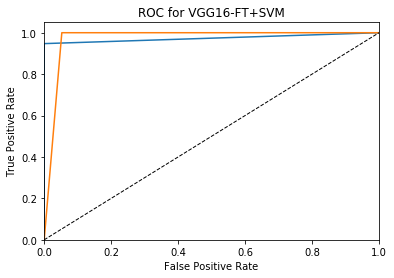

In [23]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


# Plot all ROC curves
#plt.figure()
#plt.figure(figsize = (10,2))

#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', marker=11, linewidth=1)

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', marker=5, linewidth=1)


colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9,25)]  

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], 
             label='ROC curve of Family {0} (area = {1:0.2f})'
             ''.format(list_fams[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for VGG16-FT+SVM')
#plt.legend(loc="lower right", fontsize='small')
plt.savefig('ROC for VGG16-FT+SVM.png', transparent=True)
plt.show()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix  
#print(confusion_matrix(cls_test,cls_pred))  
print(classification_report(y_test,y_pred,target_names=list_fams)) 

              precision    recall  f1-score   support

      Packed       1.00      0.95      0.97        19
    Unpacked       0.96      1.00      0.98        26

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45



Plotting the confusion matrix normalized


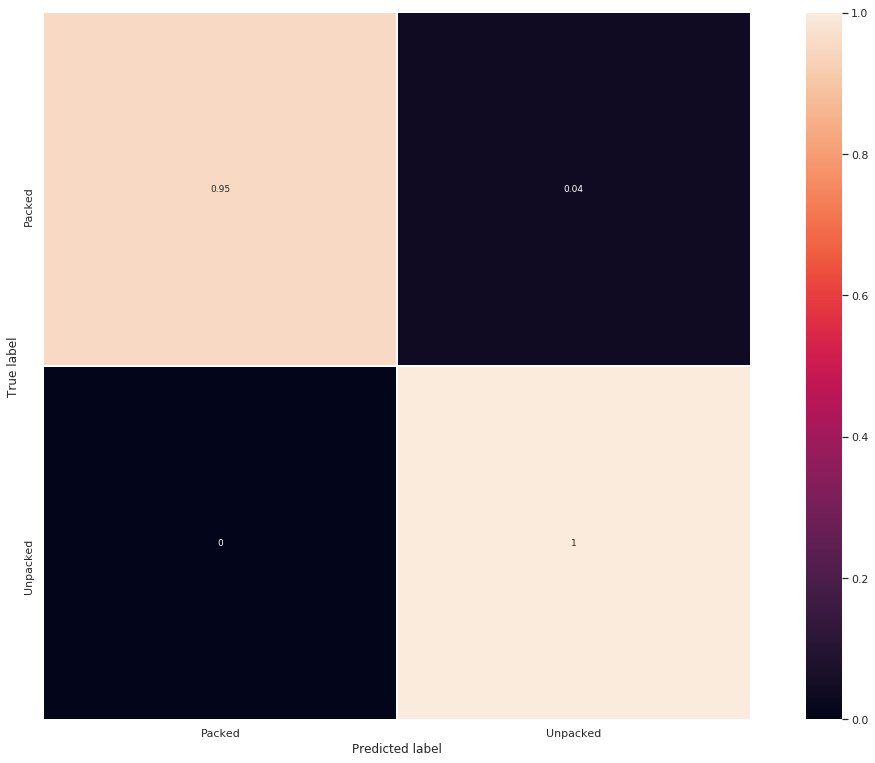

In [25]:
import seaborn as sns



conf_mat = confusion_matrix(y_test,y_pred)  # Compute confusion matrix 


print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 13)
sns.set(font_scale=1)
hm = sns.heatmap(conf_mat_norm, cbar=True, annot=True, square=True,
                 annot_kws={'size': 9}, linewidth = 0.1,
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
CM_VGG16_FT_SVM.F1

{0.0: 0.972972972972973, 1.0: 0.9811320754716981}

In [26]:
# VGG16 Transfer Learned PCA Applied